In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

from torchview import draw_graph
from IPython.display import display, HTML

from common import h5dataset, model_dnn, onnxexporter, trainer_gan

class Discriminator(nn.Module):
    def __init__(self, name: str, input_size : int, embedding_size :int, hidden_size :list, output_size :int):
        super(Discriminator, self).__init__()
        self.name = name + "_" + "_".join(map(str, hidden_size)) + "_dnn"
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.flat = nn.Flatten()
        dim_in = input_size * embedding_size + 9 # 9 for action one-hot encoding
        layers = []
        for h in hidden_size:
            layers.append(nn.Linear(dim_in, h))
            layers.append(nn.ReLU())
            dim_in = h
        layers.append(nn.Linear(dim_in, output_size))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, state, action) -> torch.Tensor:
        x = self.forward_embedded(state)
        x = self.forward_layers(torch.cat((x, action), dim=1))
        return x
    
    def forward_embedded(self, x) -> torch.Tensor:
        x = self.embedding(x)
        x = self.flat(x)
        return x
    
    def forward_layers(self, x) -> torch.Tensor:
        x = self.layers(x)
        return x

    

In [8]:
# Plot model graph
model = model_dnn.ModelDNN(
    name="JassGanGen",
    input_size=72,
    embedding_size=13,
    hidden_size=[512, 256, 128],
    output_size=9,
)
model_graph = draw_graph(model, torch.zeros(1, 72).long(), show_shapes=True)

discriminator = Discriminator(
    name="JassGanDisc",
    input_size=72,
    embedding_size=13,
    hidden_size=[1024, 512, 256, 128],
    output_size=1,
)

discriminator_graph = draw_graph(discriminator, (torch.zeros(1, 72).long(), torch.zeros(1, 9).long()), show_shapes=True)

model_svg = model_graph.visual_graph.pipe(format="svg").decode("utf-8")
discriminator_svg = discriminator_graph.visual_graph.pipe(format="svg").decode("utf-8")

display(HTML(
    f"""
    <div style="display: flex; flex-direction: row; gap: 40px;">
        <div>{model_svg}</div>
        <div>{discriminator_svg}</div>
    </div>
    """
))

In [9]:
DATASET_PATH = '../log_parser/dataset/flat_playing.hdf5'
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATASET_PATH}")

MODLE_PATH = './models/play_gan'
if not os.path.exists(MODLE_PATH):
    os.makedirs(MODLE_PATH)

LOGS_PATH = './logs/play_gan'
if not os.path.exists(LOGS_PATH):
    os.makedirs(LOGS_PATH)

In [10]:

BATCH_SIZE = 256
NUM_EPOCHS = 15
LEARNING_RATE = 1e-4
SEED = 42

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
dataset = h5dataset.H5Dataset(DATASET_PATH)
train_dataset, val_dataset = dataset.split(0.8)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)


#model.load_state_dict(torch.load(f"{MODLE_PATH}/JassPlayDNN_512_256_128.pth"))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
discriminator = discriminator.to(device)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)
accuracy_fn = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).float().mean()

# set up trainer
trainer = trainer_gan.TrainerGan(
    train_loader=train_loader,
    val_loader=val_loader,
    model_path=MODLE_PATH,
    device=device
)

Using device: cuda


In [11]:
# train the model
trainer.train(NUM_EPOCHS, model, discriminator, optimizer, disc_optimizer)
torch.save(model.state_dict(), f"{MODLE_PATH}/{model.name}.pth")
torch.save(discriminator.state_dict(), f"{MODLE_PATH}/{discriminator.name}.pth")

Training Epoch 1: 100%|██████████| 69304/69304 [08:32<00:00, 135.11it/s]


Generator steps: 23636, Discriminator steps: 45668


Validation Epoch 1: 100%|██████████| 17326/17326 [01:04<00:00, 268.86it/s]


Epoch 1/15 - Generator Train Loss: 0.2085, Discriminator Train Loss: -0.0819, Generator Val Loss: -0.0401, Discriminator Val Loss: -0.0466


Training Epoch 2: 100%|██████████| 69304/69304 [10:27<00:00, 110.46it/s]


Generator steps: 13689, Discriminator steps: 55615


Validation Epoch 2: 100%|██████████| 17326/17326 [00:57<00:00, 300.49it/s]


Epoch 2/15 - Generator Train Loss: 0.0810, Discriminator Train Loss: -0.0553, Generator Val Loss: -0.0103, Discriminator Val Loss: -0.0454


Training Epoch 3: 100%|██████████| 69304/69304 [10:21<00:00, 111.58it/s]


Generator steps: 12225, Discriminator steps: 57079


Validation Epoch 3: 100%|██████████| 17326/17326 [01:04<00:00, 268.91it/s]


Epoch 3/15 - Generator Train Loss: 0.0252, Discriminator Train Loss: -0.0534, Generator Val Loss: -0.0319, Discriminator Val Loss: -0.0433


Training Epoch 4: 100%|██████████| 69304/69304 [09:37<00:00, 120.03it/s]


Generator steps: 18064, Discriminator steps: 51240


Validation Epoch 4: 100%|██████████| 17326/17326 [00:56<00:00, 306.85it/s]


Epoch 4/15 - Generator Train Loss: -0.0224, Discriminator Train Loss: -0.0702, Generator Val Loss: 0.2359, Discriminator Val Loss: -0.0761


Training Epoch 5: 100%|██████████| 69304/69304 [07:48<00:00, 147.87it/s]


Generator steps: 25220, Discriminator steps: 44084


Validation Epoch 5: 100%|██████████| 17326/17326 [00:56<00:00, 304.54it/s]


Epoch 5/15 - Generator Train Loss: -0.0355, Discriminator Train Loss: -0.0802, Generator Val Loss: -0.0311, Discriminator Val Loss: -0.0637


Training Epoch 6: 100%|██████████| 69304/69304 [08:09<00:00, 141.54it/s]


Generator steps: 26455, Discriminator steps: 42849


Validation Epoch 6: 100%|██████████| 17326/17326 [01:01<00:00, 280.60it/s]


Epoch 6/15 - Generator Train Loss: -0.1405, Discriminator Train Loss: -0.0776, Generator Val Loss: -0.1924, Discriminator Val Loss: -0.1059


Training Epoch 7: 100%|██████████| 69304/69304 [08:57<00:00, 128.93it/s]


Generator steps: 14140, Discriminator steps: 55164


Validation Epoch 7: 100%|██████████| 17326/17326 [00:58<00:00, 296.97it/s]


Epoch 7/15 - Generator Train Loss: -0.3432, Discriminator Train Loss: -0.0987, Generator Val Loss: -0.4126, Discriminator Val Loss: -0.1108


Training Epoch 8: 100%|██████████| 69304/69304 [08:23<00:00, 137.63it/s]


Generator steps: 11556, Discriminator steps: 57748


Validation Epoch 8: 100%|██████████| 17326/17326 [00:58<00:00, 298.67it/s]


Epoch 8/15 - Generator Train Loss: -0.4976, Discriminator Train Loss: -0.0993, Generator Val Loss: -0.5757, Discriminator Val Loss: -0.1015


Training Epoch 9: 100%|██████████| 69304/69304 [08:04<00:00, 143.18it/s]


Generator steps: 11554, Discriminator steps: 57750


Validation Epoch 9: 100%|██████████| 17326/17326 [00:56<00:00, 308.81it/s]


Epoch 9/15 - Generator Train Loss: -0.5695, Discriminator Train Loss: -0.0899, Generator Val Loss: -0.6060, Discriminator Val Loss: -0.0923


Training Epoch 10: 100%|██████████| 69304/69304 [08:11<00:00, 141.05it/s]


Generator steps: 11551, Discriminator steps: 57753


Validation Epoch 10: 100%|██████████| 17326/17326 [00:56<00:00, 305.45it/s]


Epoch 10/15 - Generator Train Loss: -0.6395, Discriminator Train Loss: -0.0859, Generator Val Loss: -0.6566, Discriminator Val Loss: -0.0914


Training Epoch 11: 100%|██████████| 69304/69304 [09:49<00:00, 117.50it/s]


Generator steps: 11552, Discriminator steps: 57752


Validation Epoch 11: 100%|██████████| 17326/17326 [01:04<00:00, 267.80it/s]


Epoch 11/15 - Generator Train Loss: -0.7095, Discriminator Train Loss: -0.0849, Generator Val Loss: -0.7647, Discriminator Val Loss: -0.0914


Training Epoch 12: 100%|██████████| 69304/69304 [10:48<00:00, 106.79it/s]


Generator steps: 11553, Discriminator steps: 57751


Validation Epoch 12: 100%|██████████| 17326/17326 [01:04<00:00, 268.08it/s]


Epoch 12/15 - Generator Train Loss: -0.7529, Discriminator Train Loss: -0.0844, Generator Val Loss: -0.7873, Discriminator Val Loss: -0.0908


Training Epoch 13: 100%|██████████| 69304/69304 [10:46<00:00, 107.20it/s]


Generator steps: 11551, Discriminator steps: 57753


Validation Epoch 13: 100%|██████████| 17326/17326 [01:04<00:00, 269.34it/s]


Epoch 13/15 - Generator Train Loss: -0.7620, Discriminator Train Loss: -0.0857, Generator Val Loss: -0.7373, Discriminator Val Loss: -0.0952


Training Epoch 14: 100%|██████████| 69304/69304 [09:01<00:00, 127.95it/s]


Generator steps: 11551, Discriminator steps: 57753


Validation Epoch 14: 100%|██████████| 17326/17326 [00:59<00:00, 292.31it/s]


Epoch 14/15 - Generator Train Loss: -0.7651, Discriminator Train Loss: -0.0865, Generator Val Loss: -0.7807, Discriminator Val Loss: -0.0925


Training Epoch 15: 100%|██████████| 69304/69304 [09:37<00:00, 119.95it/s]


Generator steps: 11551, Discriminator steps: 57753


Validation Epoch 15: 100%|██████████| 17326/17326 [01:00<00:00, 286.45it/s]

Epoch 15/15 - Generator Train Loss: -0.7796, Discriminator Train Loss: -0.0869, Generator Val Loss: -0.7683, Discriminator Val Loss: -0.0909


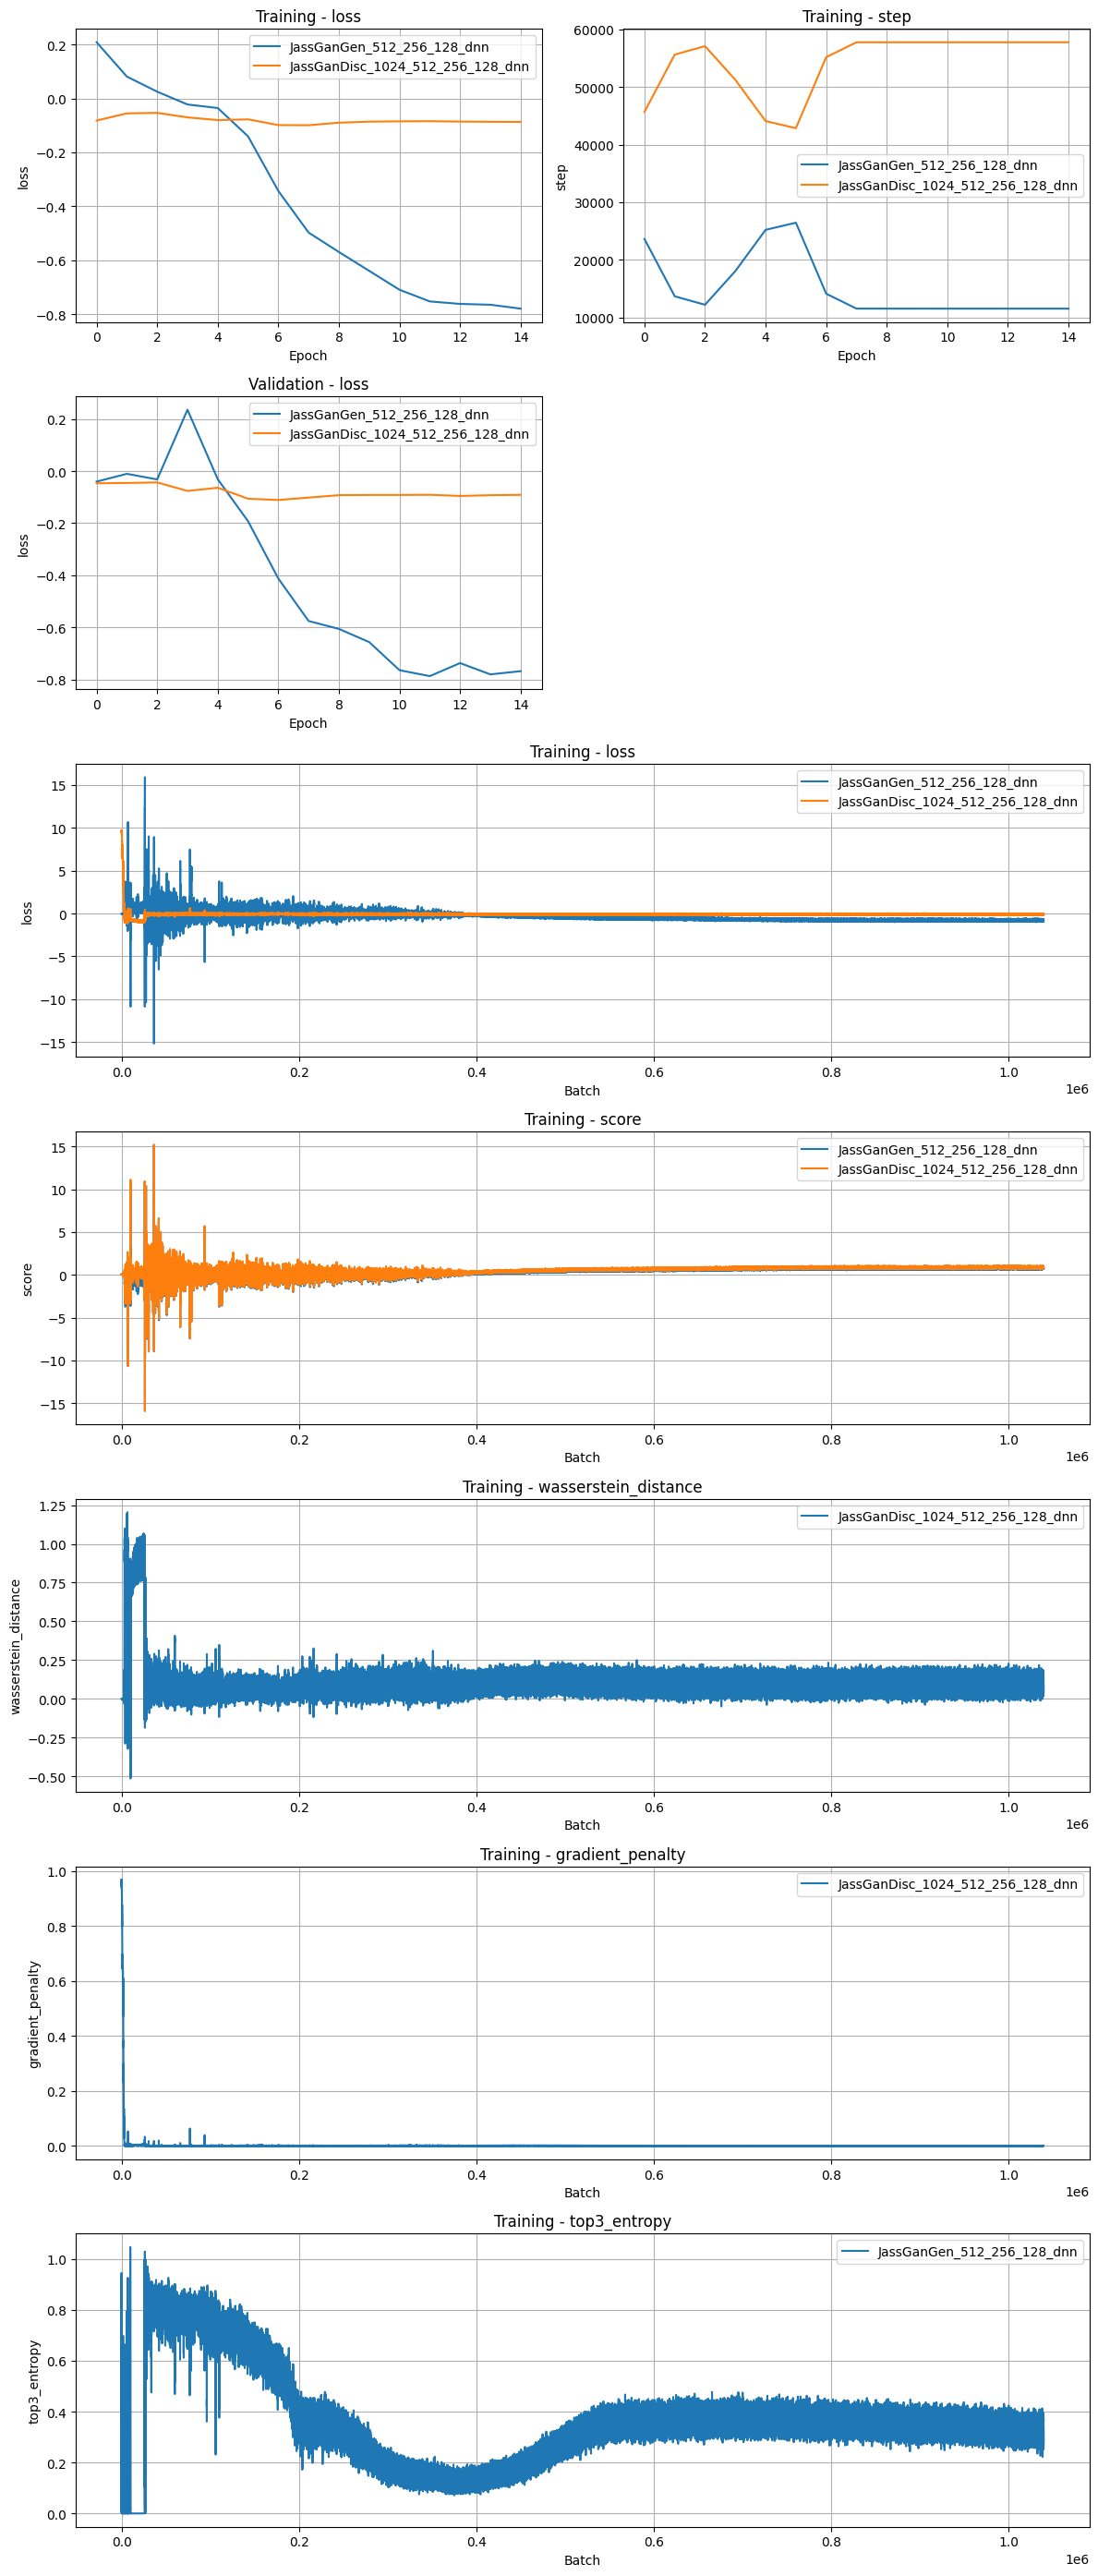

In [12]:
# create graphs
trainer.monitor.plot()

In [13]:
trainer.monitor.dump(dump_path=LOGS_PATH, filename="monitor")

In [ ]:
# export the model to ONNX
ONNX_PATH = f"{MODLE_PATH}/{model.name}.onnx"
model = model_dnn.ModelDNN(
    name="JassGanGen",
    input_size=72,
    embedding_size=13,
    hidden_size=[512, 256, 128],
    output_size=9,
)
model.load_state_dict(torch.load(f"{MODLE_PATH}/{model.name}.pth"))
onnxexporter.onnx_exporter(
    model=model,
    decision_fn=F.log_softmax,
    in_dim=72,
    output_path=ONNX_PATH
)

Exporting model to ONNX format...
Successfully converted and saved ONNX model to ./models/play_gan/JassGanGen_512_256_128_dnn.onnx
